In [1]:
import numpy as np
import math
np.random.seed(123)
from scipy.linalg import cholesky, solve_triangular
import random
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import norm

## Gaussian Process Regression
Jun 30, 2017 Kejia Shi

In [2]:
# True function: y = f(x) = sin(5x) * (1 - tan(x^2))
# Noise level (beta_inv) is set to 0.1.

beta_inv = 0.1

def y(x):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))

def t(x, beta_inv):
    # p(t_n|y_n)
    return y(x) + np.random.randn() * beta_inv

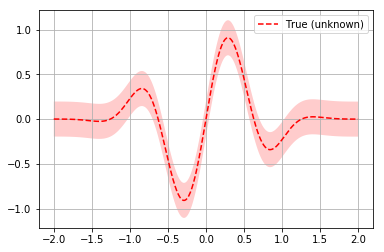

In [3]:
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [t(x_i, beta_inv=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
# Plot the 95% confidence interval
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.96 * beta_inv for fx_i in fx], 
                         [fx_i + 1.96 * beta_inv for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

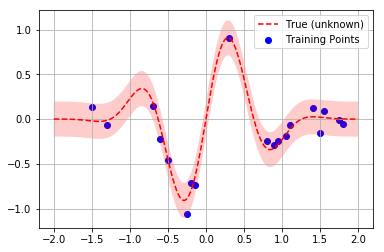

In [4]:
# Let's pick several points
x_val = np.array([-1.5, -1.3, -0.7, -0.6, -0.5, -0.2, -0.25, -0.15, 0.3, 0.8,
                  0.9, 0.95, 1.05, 1.1, 1.4, 1.5, 1.55, 1.75, 1.8])
x_val = x_val[:, np.newaxis]
y_val = np.array([t(x, beta_inv=0.1) for x in x_val])
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [t(x_i, beta_inv=0.0) for x_i in x]

plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * beta_inv for fx_i in fx], 
                         [fx_i + 1.9600 * beta_inv for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.scatter(x_val, y_val, color='blue', label="Training Points")
plt.legend()
plt.grid()
plt.show()

### 1. Try to fit a polynomial model

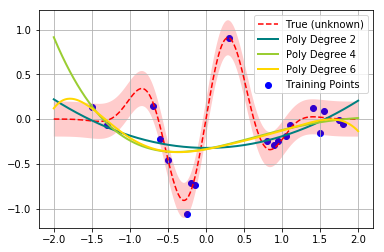

In [5]:
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * beta_inv for fx_i in fx],
                         [fx_i + 1.9600 * beta_inv for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.scatter(x_val, y_val, color='blue', label="Training Points")
colors = ['teal', 'yellowgreen', 'gold']
for count, degree in enumerate([2, 4, 6]):
    model = PolynomialFeatures(degree)
    x_val_deg = model.fit_transform(x_val)
    x_deg = model.transform(x)
    model = Ridge()
    model.fit(x_val_deg, y_val)
    y_pred = model.predict(x_deg)
    plt.plot(x, y_pred, color=colors[count], linewidth=2,
             label="Poly Degree %d" % degree)
plt.legend()
plt.grid()
plt.show()

Polynomial regression can fit very badly.

### 2. Build Gaussian Process Regression

We introduce noise on the observed target values $t_n=y_n+\epsilon_n$, where $y_n=y(\textbf{x}_n)$, with $\epsilon_n$ being the i.i.d. noise. Let $p(t_n|y_n)=\mathcal{N}(t_n|y_n,\beta^{-1})$, where $\beta$ being the precision of the noise.

Now we have the joint conditional distribution of the target values $\textbf{t}=(t_1,...,t_N)^T$ conditioned on the values of $\textbf{y}=(y_1,...,y_N)^T$ given by the Gaussian of the form $p(\textbf{t}| \textbf{y} )=\mathcal{N}(\textbf{t}|\textbf{y}, \beta^{-1}\textbf{I}_N)$.

Hence the marginal distribution $p(\textbf{y})$ is given by a zero-mean Gaussian with its covariance being a Gram matrix $p(\textbf{y})=\mathcal{N}(\textbf{y}|\textbf{0}, \textbf{K})$. And the marginal distribution $p(\textbf{y})$ is given by $p(\textbf{t})=\int p(\textbf{t}| \textbf{y} )p(\textbf{y})d\textbf{y}=\mathcal{N}(\textbf{t}|\textbf{0}, \textbf{C})$, where $C(\textbf{x}_n,\textbf{x}_m)=k(\textbf{x}_n,\textbf{x}_m)+\beta^{-1}\delta_{nm}$.

Here, the objective function is $$\ln P(\textbf{t}|\Theta) = -\frac{1}{2}\ln|\textbf{C}_N|-\frac{1}{2}\textbf{t}^T\textbf{C}_N^{-1}\textbf{t}-\frac{N}{2}\ln(2\pi)$$

Since $\frac{\partial}{\partial x}(\textbf{A}^{-1})=-\textbf{A}^{-1}\frac{\partial \textbf{A}}{\partial x}\textbf{A}^{-1}$ and $\frac{\partial}{\partial x}\ln|\textbf{A}|=\text{Tr}\left(\textbf{A}^{-1}\frac{\partial \textbf{A}}{\partial x} \right)$, by the chain rule, the derivative is

$$\frac{\partial}{\partial \theta_i} \ln P(\textbf{t}|\Theta) = -\frac{1}{2}\text{Tr}\left({\textbf{C}_N}^{-1}\frac{\partial \textbf{C}_N}{\partial \theta_i}\right) + 
\frac{1}{2}\textbf{t}^T\textbf{C}_N^{-1}\frac{\partial \textbf{C}_N}{\partial \theta_i}\textbf{C}_N^{-1}\textbf{t}$$

There are many choices for the kernel function. A good selection of kernel function can be essential to the fitting and predicting process.

A widely used parametric kernel/covariance function for regression is given by the **exponential of a quadratic** form:$$K(\textbf{x}_n,\textbf{x}_m) = \theta_0 \exp\left(-\frac{\theta_1}{2}(\textbf{x}_n-\textbf{x}_m)^T(\textbf{x}_n-\textbf{x}_m)\right)+\theta_2+\theta_3\textbf{x}_n^T\textbf{x}_m$$

Take partial derivatives 
$$\frac{\partial K}{\partial \theta_0} = \exp\left(-\frac{\theta_1}{2}(\textbf{x}_n-\textbf{x}_m)^T(\textbf{x}_n-\textbf{x}_m)\right)$$
$$\frac{\partial K}{\partial \theta_1} = -\frac{\theta_0}{2} \exp\left(-\frac{\theta_1}{2}(\textbf{x}_n-\textbf{x}_m)^T(\textbf{x}_n-\textbf{x}_m)\right)(\textbf{x}_n-\textbf{x}_m)^T(\textbf{x}_n-\textbf{x}_m)$$
$$\frac{\partial K}{\partial \theta_2} = 1, \frac{\partial K}{\partial \theta_3} = \textbf{x}_n^T\textbf{x}_m$$



In [6]:
def kernel(X, Theta, type_, return_pd=True):
    '''
    Calculate the values and the partial derivatives of 
    the assigned kernel

    X    : The data matrix, with dimension (N, p), 
           N data points and each with p dimensions

    n_hyp: Number of hyper parameters

    Theta: Dimensions depends on the kernels

    type_: "SquaredExponential" or "ExponentiatedQuadratic"

    '''
    if return_pd == True:

        if type_ == "SquaredExponential":
            n_hyp, K, pd_K = K_sq_exp(X, Theta, return_pd)
        elif type_ == "ExponentiatedQuadratic":
            n_hyp, K, pd_K = K_exp_quad(X, Theta, return_pd)
        else:
            raise "Kernel function not suppoeted."
        return n_hyp, K, pd_K

    else:

        if type_ == "SquaredExponential":
            n_hyp, K = K_sq_exp(X, Theta, return_pd)
        elif type_ == "ExponentiatedQuadratic":
            n_hyp, K = K_exp_quad(X, Theta, return_pd)
        else:
            raise "Kernel function not suppoeted."
        return n_hyp, K

In [7]:
def calc_exp_quad(x_i, x_j, Theta):
    x_i = np.reshape(np.array(x_i), (1,-1))
    x_j = np.reshape(np.array(x_j), (1,-1))
    gap = x_i - x_j
    # Calculate the two inner product with Einstein summation
    quad_1 = np.einsum('ij,ij->i', gap, gap)
    quad_2 = np.einsum('ij,ij->i', x_i, x_j)
    # Calculate kernal values
    k = Theta[0] * np.exp(-.5 * Theta[1] * quad_1) + Theta[2] + Theta[3] * quad_2
    return quad_1, quad_2, k

In [8]:
def K_exp_quad(X, Theta, return_pd=True):
    '''
    Calculate the values and the partial derivatives of 
    the **exponentiated quadratic kernel function**

    X    : The data matrix, with dimension (N, p), 
           N data points and each with p dimensions

    n_hyp: Number of hyper parameters

    Theta: 4 dimensions (theta0, theta1, theta2, theta3)

    '''
    N = X.shape[1]
    # Kernel matrix
    K = np.zeros((N, N))
    # Partial derivative matrices
    n_hyp = 4
    if return_pd == True:
        pd_K = np.zeros((n_hyp, N, N))
        # one dimension is known
        pd_K[2] = np.ones((N, N))

    for i in range(N):
        for j in range(N):
            quad_1, quad_2, K[i, j] = calc_exp_quad(X[i, ], X[j, ], Theta)
            if return_pd == True:
                # Calculate partial derivatives
                pd_K[0, i, j] = np.exp(-.5 * Theta[1] * quad_1)
                pd_K[1, i, j] = -.5 * Theta[0] * np.exp(-.5 * Theta[1] * quad_1) * quad_1
                pd_K[3, i, j] = quad_2

    if return_pd == True:
        return n_hyp, K, pd_K
    else:
        return n_hyp, K

In [9]:
def objective(X, t, Theta, type_="ExponentiatedQuadratic", return_pd=True):
    '''
    Calculate the objective function and the derivatives
    of the objective function

    X    : The data matrix, with dimension (N, p),
           N data points and each with p dimensions

    n_hyp: Number of hyper parameters

    t    : The observed values, which is true value plus noise

    Theta: Dimensions depends on the kernels
    '''
    pd_obj = np.zeros(Theta.size)
    n_hyp, K, pd_K = kernel(X, Theta, type_, return_pd=True)
    N = X.shape[0]
    t = np.asarray(t).reshape((1, -1))

    # K is a symmetric positive definite matrix, which is bounded
    # Calculate the inverse kernel matrix
    L = cholesky(K, lower=True)
    L_inv = solve_triangular(L.T, np.eye(L.shape[0]))
    K_inv = L_inv.dot(L_inv.T)

    # Calculate objective function
    obj = - .5 * np.log(np.linalg.det(K)) - .5 * np.einsum('ij,jk,kl->il', t.T, K_inv, t) - N / 2. * np.log(2 * np.math.pi)

    # Calculate partial derivatives
    for i in range(Theta.size):
        tr = np.einsum('ij,ji->', K_inv, pd_K[i])
        mul = np.einsum('ij,jk,kl,lm,mn->', t.T, K_inv, pd_K[i], K_inv, t)
        pd_obj[i] = - .5 * tr + .5 * mul

    return K, obj, pd_obj

In [10]:
def train(X, t, epoch=1000, stepsize=.01, type_="ExponentiatedQuadratic", return_pd=True):
    if type_ == "ExponentiatedQuadratic":
        n_hyp = 4
    elif type_ == "SquaredExponential":
        n_hyp = 2
    else:
        raise "Kernel function not suppoeted."
    Theta = np.random.rand(n_hyp)
    K, _, pd_obj = objective(X, t, Theta, type_, return_pd=True)
    for i in range(epoch):
        Theta = Theta + stepsize * pd_obj
    return K, _, Theta

In [11]:
def predict(X, x_new, K, Theta, beta_inv):
    N = K.shape[0]
    C = K + beta_inv * np.eye(N)
    _, _, c = calc_exp_quad(X, x_new, Theta)
    c = c + beta_inv
    k_new = np.zeros((N, 1))
    for i in range(N):
        _, _, k_new[i] = calc_exp_quad(X, x_new, Theta) # np.array with dimension N
    L = cholesky(C, lower=True)
    L_inv = solve_triangular(L.T, np.eye(L.shape[0]))
    C_inv = L_inv.dot(L_inv.T)
    mean_pred = (k_new.T * C_inv * t(x_new, beta_inv))[0]
    var_pred = c - np.einsum('ij,jk,kl->il', k_new.T, C_inv, k_new)
    return mean_pred, var_pred

/Users/kj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/Users/kj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


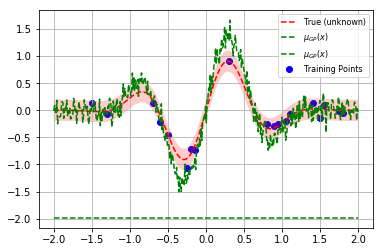

In [22]:
# Generate the same grid and calculate the predicted values
beta_inv = 0.1
x = np.linspace(-2, 2, 400).reshape(-1, 1)
K, _, Theta = train(x_val, y_val, epoch=1000, stepsize=.01)
fx_pred = np.empty((400, 2), float)
i = 0
for x_new in x:
    fx_foo, sd_foo = predict(x, x_new, K, Theta, beta_inv)
    fx_pred[i, 0] = fx_foo[0]
    fx_pred[i, 1] = sd_foo[0]
    i += 1

# Plot f(x) + contours + sampled points
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * beta_inv for fx_i in fx],
                         [fx_i + 1.9600 * beta_inv for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.scatter(x_val, y_val, color='blue', label="Training Points")

# Plot GP(x) + contours
plt.plot(x, fx_pred, "g--", label=r"$\mu_{GP}(x)$")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_pred[i, 0] - 1.9600 * np.sqrt(fx_pred[i, 1]) * .01 for i in range(400)],
                         [fx_pred[i, 0] + 1.9600 * np.sqrt(fx_pred[i, 1]) * .01 for i in range(400)[::-1]])),
         alpha=.2, fc="g", ec="None")

plt.legend(loc="best", prop={'size': 8}, numpoints=1)
plt.grid()
plt.show()

Another widely used parametric kernel/covariance function for regression is the **squared exponential kernel**:$$K(\textbf{x}_n,\textbf{x}_m) = \tau^2 \exp\left(-\frac{1}{2l^2}(\textbf{x}_n-\textbf{x}_m)^T(\textbf{x}_n-\textbf{x}_m)\right)$$

Take partial derivatives 
$$\frac{\partial K}{\partial \tau} = 2 \tau \exp\left(-\frac{1}{2l^2}(\textbf{x}_n-\textbf{x}_m)^T(\textbf{x}_n-\textbf{x}_m)\right)$$
$$\frac{\partial K}{\partial l} = \frac{\tau^2}{l^3} \exp\left(-\frac{1}{2l^2}(\textbf{x}_n-\textbf{x}_m)^T(\textbf{x}_n-\textbf{x}_m)\right)(\textbf{x}_n-\textbf{x}_m)^T(\textbf{x}_n-\textbf{x}_m)$$

In [21]:
def K_sq_exp(X, Theta):
    '''
    Calculate the values and the partial derivatives of 
    the **squared exponential kernel function**
    This is different from the previous `calc` function

    X    : The data matrix, with dimension (N, p), 
           N data points and each with p dimensions

    Theta: 2 dimensions (tau, l)

    '''
    N = X.shape[1]
    # Kernel matrix
    K = np.zeros((N, N))
    if return_pd == True:
        # Partial derivative matrices
        pd_K = np.zeros((2, N, N))

    for i in range(N):
        for j in range(N):
            quad, K[i, j] = calc_sq_exp(X[i, ], X[j, ], Theta)
            if return_pd == True:
                # Calculate partial derivatives
                pd_K[0, i, j] = 2 * Theta[0] * np.exp(-.5 * (1. / Theta[1] ** 2) * quad)
                pd_K[1, i, j] = (Theta[0] ** 2 / Theta[1] ** 3) * np.exp(-.5 * (1. / Theta[1] ** 2) * quad) * grad

    if return_pd == True:
        return n_hyp, K, pd_K
    else:
        return n_hyp, K

In [ ]:
def calc_sq_exp(x_i, x_j, Theta):
    x_i = np.reshape(np.array(x_i), (1,-1))
    x_j = np.reshape(np.array(x_j), (1,-1))
    gap = x_i - x_j
    # Calculate the two inner product with Einstein summation
    quad = np.einsum('ij,ij->i', gap, gap)
    # Calculate kernal values
    k = Theta[0] ** 2 * np.exp(-.5 * (1. / Theta[1] ** 2) * quad)
    return quad, k